In [398]:
import json
import itertools  # itertools.combinations may be useful
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import streamlit as st
# import altair as alt
import pickle
import plotly.graph_objects as go
import plotly.express as px


In [49]:
def load_json(input):
    # Opening JSON file
    f = open(input)
    # returns JSON object as
    # a dictionary
    data = json.load(f)
    # Closing file
    f.close() 
    return data

In [50]:
# OBSOLETE
def get_cn(key,input):
    data = load_json(input)
    for i,el in enumerate(data["intervals"]):
        if el['iid']==key:
            return el['y']
        else:
            continue

    return 0

In [51]:
def draw_network(G):
    # Set overall figure size
    fig = plt.figure(figsize=(40,40))
    fig.tight_layout()

    nx.draw_networkx(G)

In [321]:
def draw_network_colors(G):
    input = 'SM12_12.json'
    node_list = list(G.nodes())
    cn = []
    for node in node_list:
        cn.append(get_cn(node,input))

    #nx.set_node_attributes(G, cn, 'cn')

    fig = plt.figure(figsize=(70,10))
    ax = fig.add_subplot(111)

    #cmap = plt.cm.get_cmap('rainbow')
    cmap = plt.cm.coolwarm
    vmin = 0
    vmax = max(cn) #if len(cn)>0 else 0
    # nx.draw(G, pos=nx.spring_layout(G), node_color = cn, vmin=vmin, vmax=vmax, cmap=cmap,with_labels=True)

    pos=nx.get_node_attributes(G,'pos')

    xmax = max([v[0] for k,v in pos.items()])
    
    nx.draw_networkx(G, pos, node_shape="s", node_color = cn, node_size=100, font_size=8,
            vmin=vmin, vmax=vmax, cmap=cmap, with_labels=True,
            ax=ax)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm,fraction=0.046, pad=0.04, aspect=10)#https://matplotlib.org/stable/api/colorbar_api.html

    ax.tick_params(left=True, right=True, top=True, bottom=True, labelleft=True, labelbottom=True)
    ax.set_title("The Longest Chain")
    ax.set_ylabel("Copy Number")
    ax.set_xlabel("Starting Position/$10^{9}$")
    #ax.set_xlim(0,xmax*1.01)
    #ax.set_xscale("log")
  

In [370]:
def find_longest_chain(G,df):
    diameter = max([max(j.values()) for (i,j) in nx.shortest_path_length(G)])
    print("the longest is path length is", diameter)

    # print(df)

    G2=nx.DiGraph()

    how_many_longest = 0

    for (i,j) in nx.shortest_path_length(G):
        # print((i,j),j.values()) # prints as below (the default longest chain)
        # (2798, {2798: 0, 2799: 1, 2800: 2, 2803: 3, 2804: 4, 2806: 5, 2807: 6, 2808: 7}) dict_values([0, 1, 2, 3, 4, 5, 6, 7])

        if max(j.values()) == diameter:

            how_many_longest += 1
            node_list = list(j.keys())
            print("node list and its length:", node_list, len(node_list))

            for n,node in enumerate(node_list):
                x1=int(df[df['Source']==node]['Start_Point'])
                x2=int(df[df['Source']==node]['End_Point'])
                y=int(df[df['Source']==node]['Copy_Number'])           
                
                # Add nodes and connect them                
                G2.add_node(node_list[n],pos=(x1,y))
                if n>0:
                    G2.add_edge(node_list[n-1],node_list[n])

    print("how many with this size:",how_many_longest)

    # print("longest chain -->",G2.nodes)

    return G2

In [102]:
def getnodeinfo(nodeID,jsonfile):
    # NEEDS ABS VAL OF SOURCE
    # Returns copy number, starpoint, endpoint information
    # from the first part of json file
    # P.S.: returning just el['y'] is the same as get_cn()
    # this returns start and end points of nodes on top of that
    
    data = load_json(jsonfile)

    for i,el in enumerate(data["intervals"]):            
        if el['iid']==nodeID:
            # if nodeID==454:
            #     print("getnodeinfo",el['y'],el['startPoint'],el['endPoint'],el['chromosome'])
            return el['y'],el['startPoint'],el['endPoint'],el['chromosome']
        else:
            continue
    
    print("getnodeinfo can't find the info")

    return 0

In [590]:
def make_dict_of_nodes(jsonfile):
    data = load_json(jsonfile)
    # Iterating through the json

    _nodegroups = {}
    for i,el in enumerate(data["connections"]): # out [:100] for test, otherwise all

        nodeID = abs(el['source'])
        
        if el['type']!='LOOSE':

            if getnodeinfo(nodeID,jsonfile)!=0:
                cn,sp,ep,chr = getnodeinfo(nodeID,jsonfile)
                _nodegroups[nodeID] =  [abs(el['sink']),cn,sp,ep,chr] # dict of lists
            else:
                _nodegroups[nodeID] =  [abs(el['sink']),0,0,0,0]
        else:

            # LOOSE EDGES
            if nodeID in _nodegroups.keys():
                # If the node w/ a Sink is detected, don't overwrite it with a Loose type
                continue
            else:
                # If the node doesn't have a Sink, use it with Loose
                # If its data entry with "sink" comes up later, it will overwrite "loose" version of it
                if getnodeinfo(nodeID,jsonfile)!=0:
                    cn,sp,ep,chr = getnodeinfo(nodeID,jsonfile)
                    _nodegroups[nodeID] =  ['loose',cn,sp,ep,chr] # dict of lists
                else:
                    _nodegroups[nodeID] =  ['loose',0,0,0,0]

    print("make nodes end",_nodegroups[454]) # just a check
                
    return _nodegroups

In [56]:
def handle_index_column(df):
    df2 = df.rename_axis('Source').reset_index()    
    return df2

In [585]:
def clean_zero_cn_nodes(df):
    return df[df['Copy_Number']!=0]

In [505]:
def position(jsonfile,_df,node):
    x1,x2,y=0,0,0
    if node in _df['Source'].to_list():
        x1=int(_df[_df['Source']==node]['Start_Point'])
        x2=int(_df[_df['Source']==node]['End_Point']) # no use for now
        y=int(_df[_df['Source']==node]['Copy_Number'])
    else:
        # some nodes doesn't have Source entry so we need to go back to the source
        # we can improve this later
        data = load_json(jsonfile)
        for i,el in enumerate(data["intervals"]):            
            if el['iid']==node:
                x1=el['startPoint']
                x2=el['endPoint']
                y=el['y']
            else:
                continue

    
    if node!='loose' and (x1==0 or x2==0):
        print("CAN'T FIND LOCATION DATA FOR",node)

    return x1,y

In [591]:
def make_df(jsonfile):
    print("Creating a DataFrame object")
    #df = make_df(jsonfile) # nodeID(source)| sink | CN(y) | start p | end p
    nodedict = make_dict_of_nodes(jsonfile) # this is a dict of lists
    #  = nodeID(source)| sink | CN(y) | start p | end p
    
    # now turn this into a pandas dataframe
    df = pd.DataFrame.from_dict(nodedict, orient='index')
    
    df.columns =['Sink', 'Copy_Number','Start_Point', 'End_Point','Chromosome']
    
    df2 = handle_index_column(df)

    print(df2)

    print("Cleaning DF object from nodes with 0 copy number")
    df_c = clean_zero_cn_nodes(df)
    
    return df2,df_c

In [588]:
def make_graph(jsonfile,df):
    G=nx.DiGraph()
    
    print("Constructing the graph")
    # from DF directly, however it sees nan values as a single node of 'nan'
    # G=nx.from_pandas_edgelist(df, 'Source', 'Sink') 

    # Alternative way
    # G.add_edges_from(zip(df_c['Source'].tolist(),df_c['Sink'].tolist())) # Will clean loose later - this gives longest 121 

    # Alternative way to include position info
    for n,node in enumerate(df['Source'].tolist()):
        #print(df[df["Source"]==node].Copy_Number)
        
        if df[df['Source']==node]['Copy_Number'].item()!=0:
            G.add_node(df['Source'][n],pos=position(jsonfile,df,node))
            sink = df[df['Source']==node]['Sink'].item()
            
            if df[df["Source"]==sink].values.tolist() != [] and int(df[df['Source']==sink]['Copy_Number'])!=0:
                G.add_node(df['Sink'][n],pos=position(jsonfile,df,df['Sink'][n])) # Will clean loose later
                G.add_edge(df['Source'][n],df['Sink'][n]) 

                
        else:
            continue


    return G

In [552]:
# Seperated this from the cell below to speed up debugging
jsonfile = 'SM12_12.json'
df,df_c = make_df(jsonfile)

Creating a DataFrame object
make nodes end ['loose', 2, 248654803, 248956422, '1']
      Source   Sink  Copy_Number  Start_Point  End_Point Chromosome
0       1545   1546            7     23820865   23821002         13
1       1508   1509            8     22132854   22133231         13
2       1506   1507            7     22111602   22111802         13
3       1376   1377            6     76152669   76153228         12
4       1373   1374           30     75632352   75632602         12
...      ...    ...          ...          ...        ...        ...
3648    3263  loose            2    156155003  159345973          7
3649    1788  loose            2    106766003  107043718         14
3650    2102  loose            1     83208603   83257441         17
3651    2812  loose            1    190184603  190214555          4
3652    2984  loose            1    170730003  170805979          6

[3653 rows x 6 columns]
Cleaning DF object from nodes with 0 copy number


In [593]:
# Construct the graph from df
_graph = make_graph(jsonfile,df) 

Constructing the graph


In [652]:
# pickle.dump(df, open('tmp/dataframe.txt', 'wb'))
# pickle.dump(df_c, open('tmp/dataframe_clean_cn0.txt', 'wb'))
# pickle.dump(_graph, open('tmp/graph.txt', 'wb'))

# df = pickle.load(open('tmp/dataframe.txt','rb'))
# df_c = pickle.load(open('tmp/dataframe_clean_cn0.txt','rb'))
# _graph = pickle.load(open('tmp/graph.txt','rb'))

In [597]:
# just a check, b/c in the previous version that has nodes with cn=0, loose was a node
if 'loose' in list(_graph.nodes):
    print("Loose is counted as a node") 

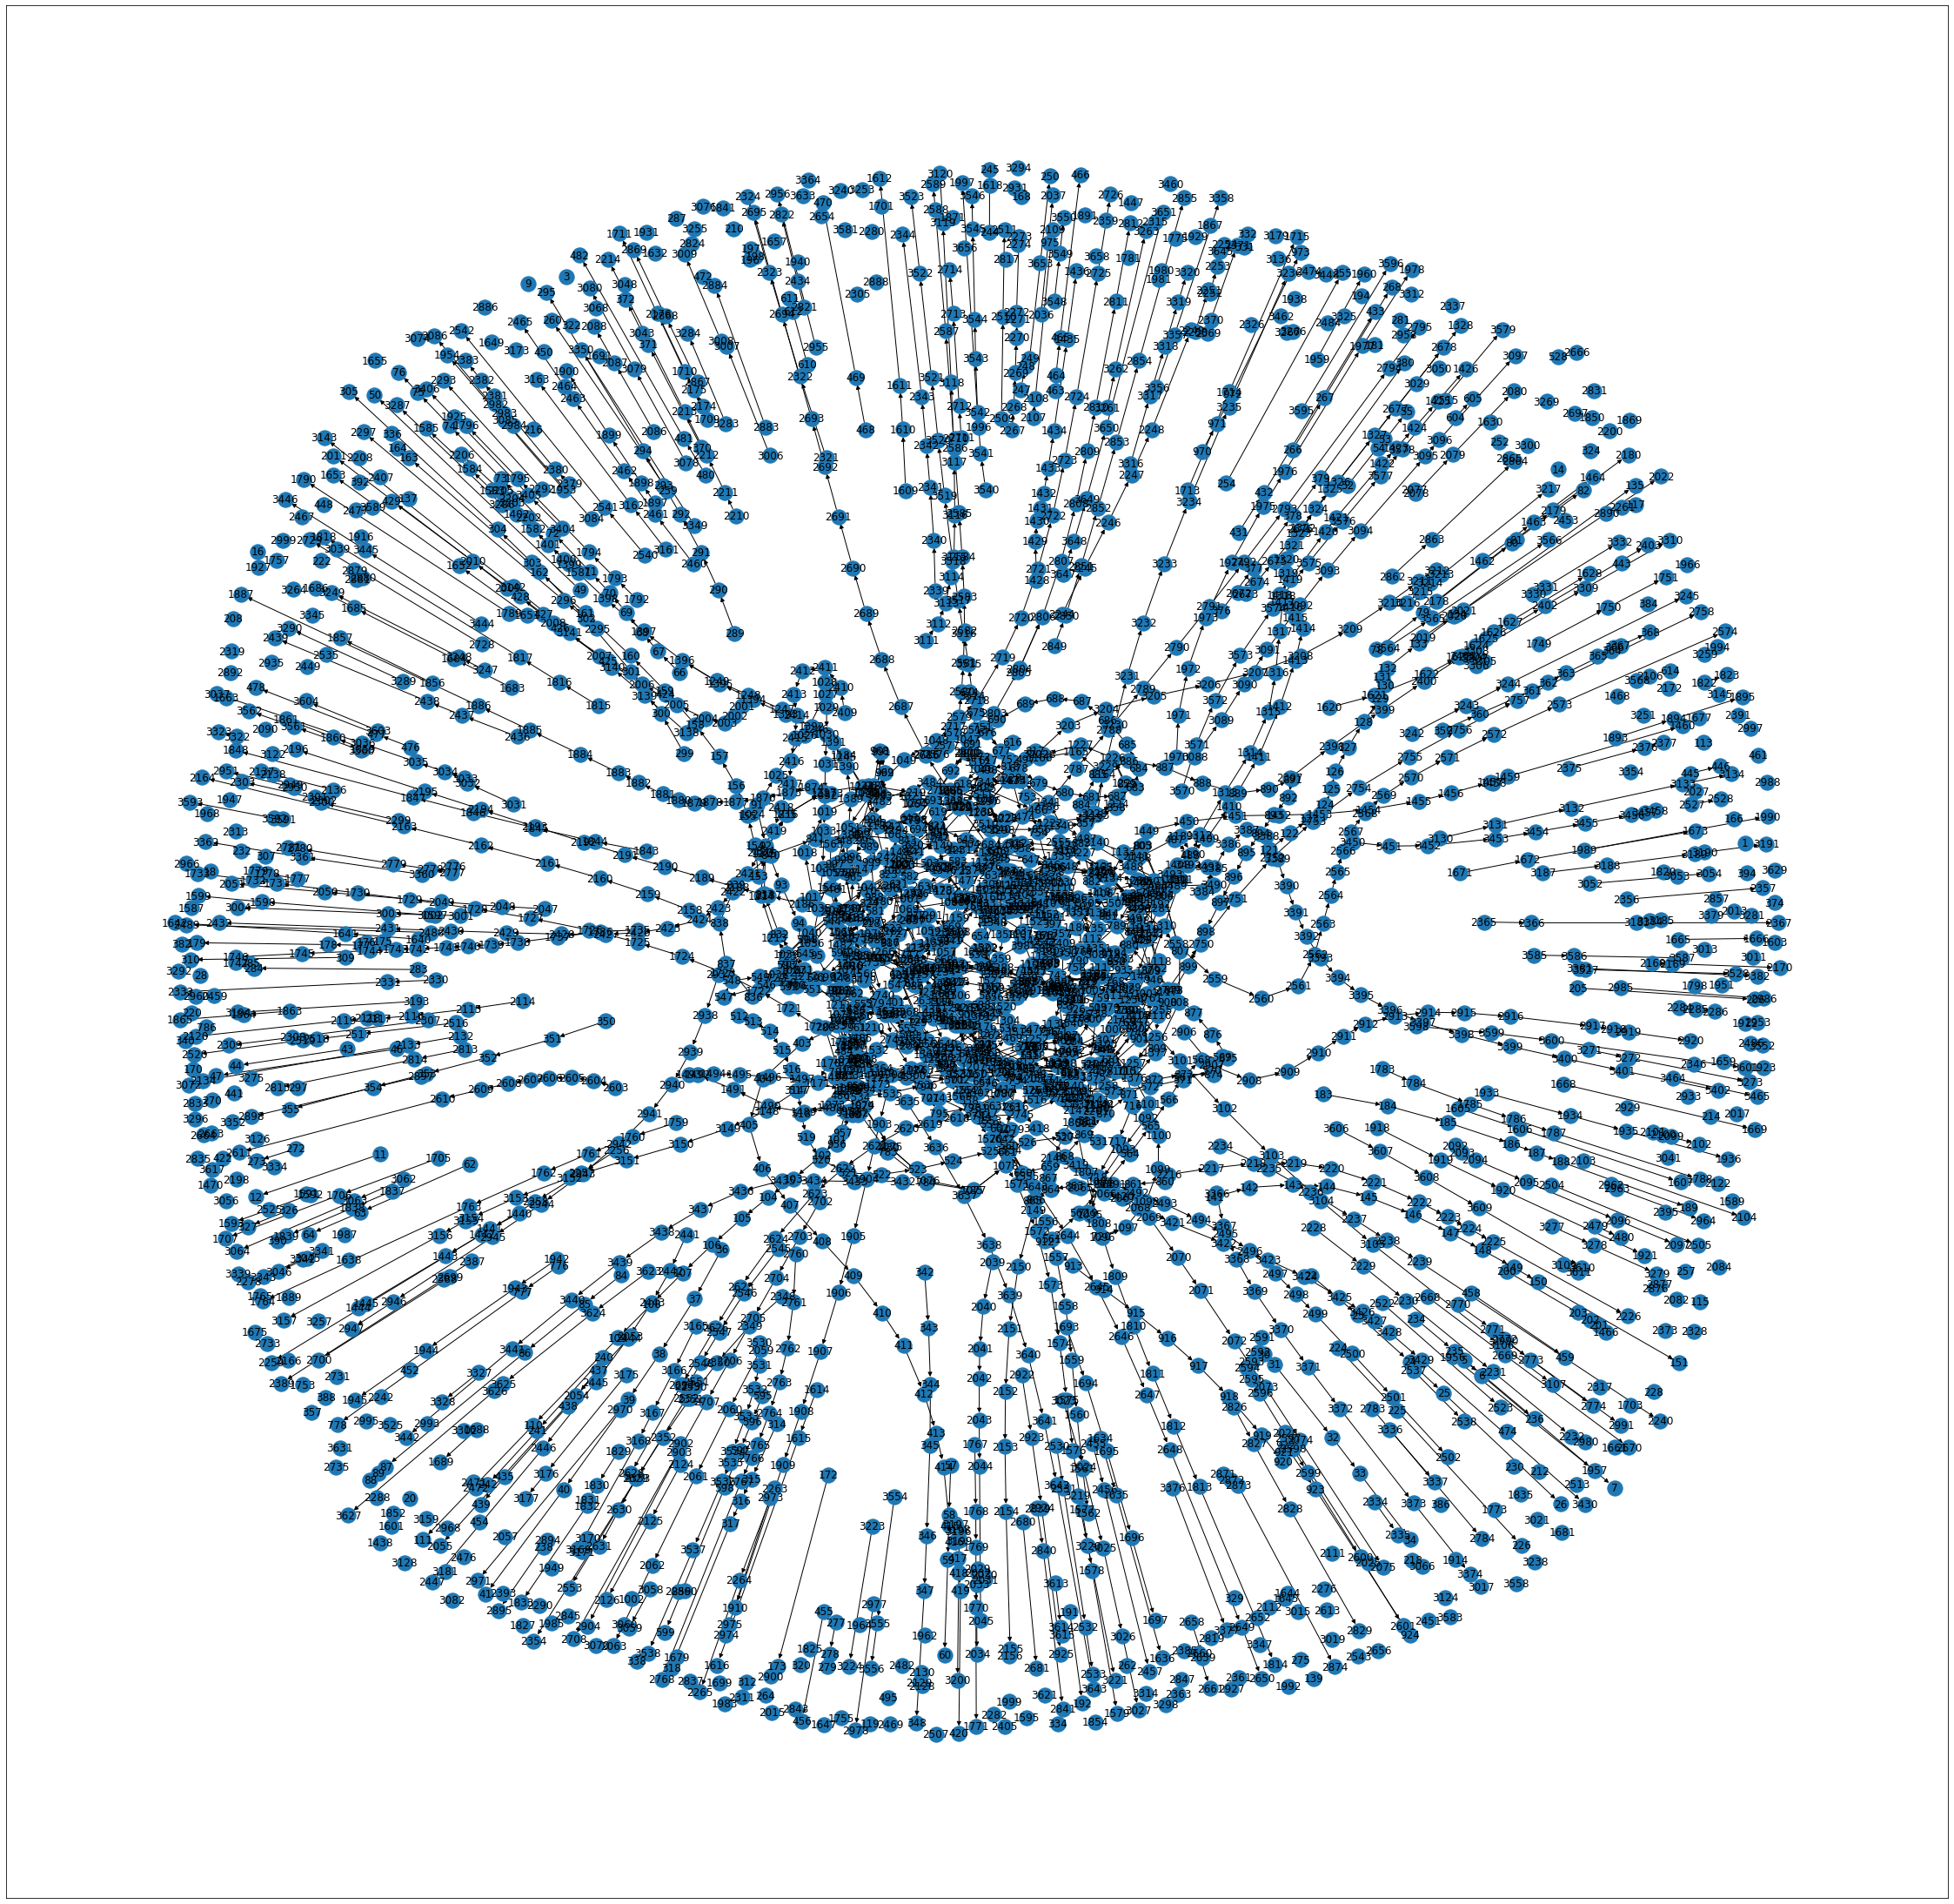

In [598]:
# _graph.remove_node('loose')
draw_network(_graph)

## FIND LONGEST CHAIN

the longest is path length is 119
node list and its length: [860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 1088, 1089, 1090, 1091, 1273, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1577, 1578, 1579] 120
how many with this size: 1


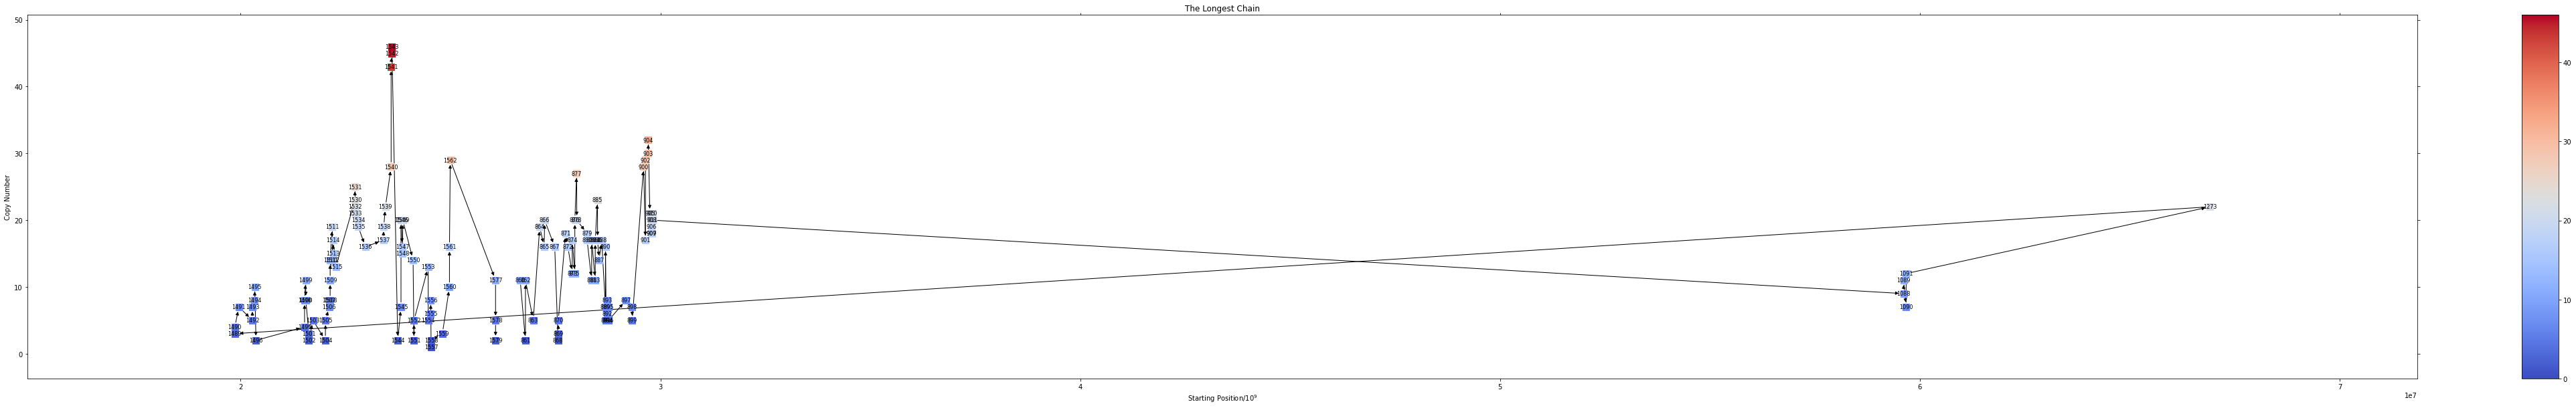

In [599]:
longest_graph = find_longest_chain(_graph,df)
draw_network_colors(longest_graph)

In [651]:
# Dump again or load longest chain faster
# pickle.dump(longest_graph, open('tmp/longest_chain.txt', 'wb'))
# longest_graph = pickle.load(open('tmp/longest_chain.txt','rb'))

## PLOTLY TEST

In [658]:
def draw_plotly(G):
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = [] # position
    node_y = [] # copy number
    node_id = [] # node id
    node_chr = []
    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)
        node_id.append(node)
        if df[df['Source']==node].Chromosome.item() == 'X':
            node_chr.append(23)
        elif df[df['Source']==node].Chromosome.item() == 'Y':
            node_chr.append(24)
        elif df[df['Source']==node].Chromosome.item() == 'M':
            node_chr.append(25)
        else:
            node_chr.append(int(df[df['Source']==node].Chromosome.item())) # item() returns numbers as str
    
    unique_values = len(set(df.Chromosome.to_list()))
    unique_values = len(set(node_chr))
    color_bar_values = [val for val in np.linspace(0, 1, unique_values+1) for _ in range(2)]
    discrete_colors = [val for val in px.colors.qualitative.Alphabet for _ in range(2)]
    colorscale = [[value, color] for value, color in zip(color_bar_values, discrete_colors[1:])]
    colorscale.pop(0)
    colorscale.pop(-1)

    ### Compile hover text for each node
    node_text = []
    for n,node in enumerate(G.nodes()):
        next_node='None' if n==len(G.nodes())-1 else list(G.nodes())[n+1]
        prev_node='None' if n==0 else list(G.nodes())[n-1]
        if node_chr[n]==23:
            node_text.append(f'Node:{node} | Prev: {prev_node} | Next: {next_node} | Chromosome: X | CN: {node_y[n]}' )
        elif node_chr[n]==24:
            node_text.append(f'Node:{node} | Prev: {prev_node} | Next: {next_node} | Chromosome: Y | CN: {node_y[n]}')
        elif node_chr[n]==25:
            node_text.append(f'Node:{node} | Prev: {prev_node} | Next: {next_node} | Chromosome: M | CN: {node_y[n]}')
        else:
            node_text.append(f'Node:{node} | Prev: {prev_node} | Next: {next_node} | Chromosome: {node_chr[n]} | CN: {node_y[n]}')


    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        text=node_text,
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            # colorscale=px.colors.qualitative.Light24,
            colorscale=colorscale,
            reversescale=True,
            color=node_chr,
            size=10,
            symbol=0,
            colorbar=dict(
                thickness=15,
                title='Chromosome Number',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))

    # Can also be assigned later like below
    # node_trace.text = node_id
    # node_trace.marker.color = node_chr

    fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Network graph of the longest chain',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=15,r=5,t=40),
                    annotations=[ dict(
                        text=f"Length of the chain: {len(node_y)}",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.1, y=1 ) ],
                    xaxis=dict(showgrid=True, zeroline=True, showticklabels=True,showline=True,title_text = "Copy Number"),
                    yaxis=dict(showgrid=True, zeroline=True, showticklabels=True,showline=True,title_text = "Start Point"))
                    )
    fig.show()

In [659]:
draw_plotly(longest_graph)

In [660]:
draw_plotly(_graph)